# Data analysis

In the following examples, we are going to have a look at classical data analysis problems: fitting a function to a data series and taking Fourier analysis of periodic signals such as sound samples. 

## Fitting a function

![smily](http://oroszl.web.elte.hu/data_smiley.png)

Many times, we have to compare the outcome of an experiment to a theoretical model, or we want to calculate the parameters from a theoretical model such that they correspond to our experiment. The most common method for solving this problem is the so called Ordinary Least Squares (OLS) fitting.

Let's assume, that our experimental data consists of $(x_i,y_i)$ pairs, and we have $N$ number of values, that is,  $i=1\dots N$! We would like to fit a $y=f(x,a,b,c,d,\dots)$ function to this data series. The task is to find the parameters $a,b,c,d,\dots$ such that the function estimates our measured data points the best. This task corresponds to the minimalization of the $$S(a,b,c,d,\dots)=\sum_{i=1}^N (y_i-f(x_i,a,b,c,d,\dots))^2$$ function, that is the sum of the squares of the deviations of the points from the function. In the next few examples, we are going to have a look at some examples from Python that use the OLS fitting method.

In [2]:
# As usual, let's load some useful modules and functions.
%matplotlib inline
from scipy.optimize import curve_fit # function used for curve fitting
from numpy.fft import *              # routines for the Fourier analysis
from scipy.signal import spectrogram # function creating a spectrogram

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [ ]:
import os
# If working in vscode, you can use the following command to change the working directory
# os.chdir('/v/wfct0p/data-ex-vis/Lectures/Timeseries')

Let us first generate a data series that we use later for experimenting. This is going to be a noisy sine.

In [3]:
t1 = linspace(0,10,100) # sampling
noise=0.3*randn(len(t1))  # Gaussian noise
x1=1.5*sin(t1+2)+noise     # a noisy sine function
error=2*abs(noise)        # the error of the measurement

Let's visualize it!

<ErrorbarContainer object of 3 artists>

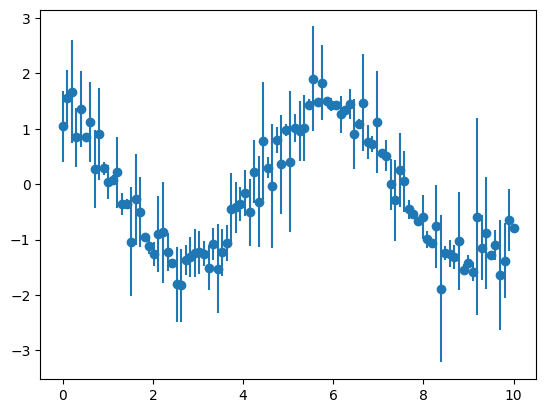

In [4]:
# fig=plt.figure()
# plt.figsize(300,300)
errorbar(t1,x1,error,marker='o',linestyle='')

We are going to use the `curve_fit` function for the fitting. Its first argument is the function that we would like to fit, let's define it! Let it be of the shape

$$f(t)=A\sin(\omega t+\varphi)!$$

In [5]:
# The function to be fitted
def fun(t,A,omega,phi):
    return A*sin(omega*t+phi)

The function `curve_fit` regards the first argument of the function as the independent variable, and the other arguments as the parameters to fit. It returns two arrays. The first contains the fitted parameters, and the second the so-called covariance matrix. The diagonal emlements of the covariance matrix give the precision of the fitted parameters.

In [6]:
popt,pcov=curve_fit(fun,t1,x1) # fit
perr = sqrt(diag(pcov))      # error
print (['A','omega','phi'])
print (popt)
print (perr)

['A', 'omega', 'phi']
[1.44338608 1.00502467 1.93939503]
[0.04074964 0.01004431 0.05491117]


The first element of the `popt` array is the parameter $A$, the second $\omega$, the third $\varphi$. As we can see, it is a rather optimal fit, because the errors of the fitted parameters are small compared to the estimated parameter values. Because we created an artificial data series by hand, if we compare the fitted values with the parameters that we used for the generation $A=1.5,\,\omega=1.0,\,\varphi=2.0$, we see that we get very close values from the fit. We can evaulate the fitted function after knowing the parameter values.

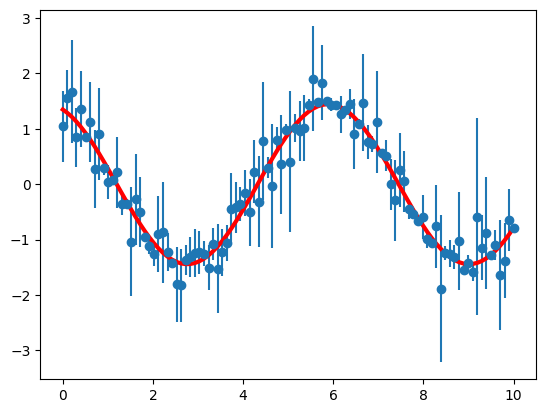

In [7]:
errorbar(t1,x1,error,marker='o',linestyle='') # plotting the data
plot(t1,fun(t1,popt[0],popt[1],popt[2]),color='red',linewidth=3) # plotting the fitted function

We can take into account the measurement errors of the individual points that we stored in the `error` variable. This means that those points that have a larger measurement error are going to weigh less into the fitting procedure than those with a smaller error. Measurement errors can be given with the `sigma` keyword argument of the `curve_fit` function. Let us observe what happens if we give the errors!

In [8]:
popt_errorval,pcov_errorval=curve_fit(fun,t1,x1,sigma=error)
perr_errorval = sqrt(diag(pcov_errorval))
print (['A','omega','phi'])
print (popt_errorval)
print (perr_errorval)

['A', 'omega', 'phi']
[1.49140528 0.9988434  2.01183202]
[0.00487183 0.00106034 0.00871821]


If we compare the fit where we took the errors into account, and the fit without the errors, we can see that the fitted parameters slightly differ, but the **error** of the fitting  is much less! Let us compare the two curves that we got! We use a more compact notation by [unpacking](https://www.geeksforgeeks.org/packing-and-unpacking-arguments-in-python/) the parameter vector.

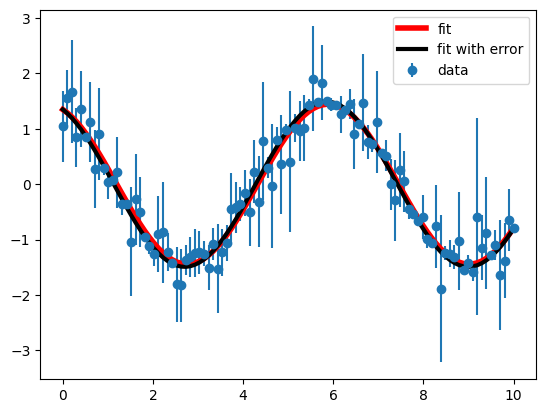

In [9]:
errorbar(t1, x1, error, marker='o', label='data', linestyle='') 
plot(t1, fun(t1, *popt), color='red', label='fit', linewidth=4)  # using unpacking               
plot(t1, fun(t1, *popt_errorval), color='black', label='fit with error', linewidth=3)  # here as well
legend()

#### An initial guess
The fit algorithms, that work behind the `curve_fit` function, cannot always find the right parameters. If there are too many parameters in a fitting task, this problem might be even more serious. Let us now observe another data series. The datafile `data/ket_gauss_plus_error` contains a noisy data series that is the sum of two Gaussians. Let's try to fit a function to it that is the sum of two Gaussians!

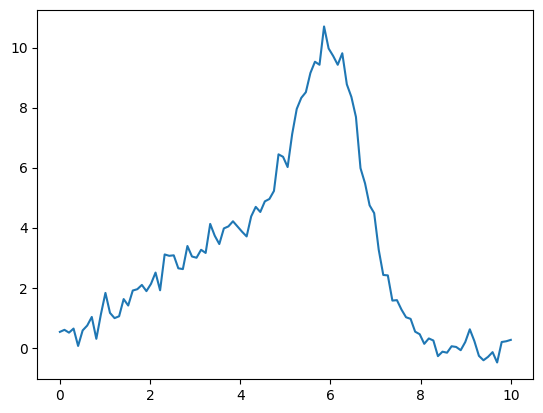

In [23]:
t2,x2=loadtxt('data/ket_gauss_plus_hiba',unpack=True) # reading
plot(t2,x2)                        # plotting

Let's define the function to fit!
$$f_2(t)=A_1\mathrm{e}^{-(t-e_1)^2/s_1^2}+A_2\mathrm{e}^{-(t-e_2)^2/s_2^2}$$

In [24]:
# The function to be fitted
def func2(t,A1,e1,s1,A2,e2,s2):
    'The sum of two Gaussians'
    return A1*exp(-((t-e1)/s1)**2)+A2*exp(-((t-e2)/s2)**2)

Let's try to do the fit!

In [25]:
popt,pcov=curve_fit(func2,t2,x2)
perr = sqrt(diag(pcov))
print (['A1','e1','s1','A2','e2','s2'])
print (popt)
print (perr)

['A1', 'e1', 's1', 'A2', 'e2', 's2']
[ 8.49188543  5.49382213  1.92673477 -1.73153175 -7.85141774  1.36682751]
[inf inf inf inf inf inf]


/tmp/ipykernel_4230/748718156.py:1: OptimizeWarning: Covariance of the parameters could not be estimated
  popt,pcov=curve_fit(func2,t2,x2)


We did not succeed. This data and the function that we want to determine illustrates the problem really well. 

The fit is more likely to be successful is we can estimate the parameters in advance. In the above data, there is a big peak around 6 that has a width of roughly 1, and a height of 10, and there is a rather broad shoulder left of this peak, that could stem from a wider and lower peak, e.g. at 4 with a with of 3 and a height if 4. Let's plot the original data with these two estimated Gaussians!

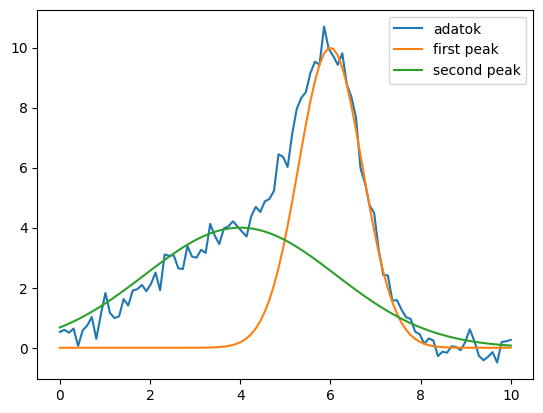

In [26]:
plot(t2,x2,label='adatok') # data
plot(t2,10*exp(-((t2-6)/1)**2),label='first peak') # larger peak
plot(t2,4*exp(-((t2-4)/3)**2),label='second peak')  # wider peak
legend()

We can give these estimated values to `curve_fit` as the initial values for the fitting procedure through the `p0` keyword argument.

In [27]:
A1=10;e1=6;s1=1
A2=4;e2=4;s2=3
popt,pcov=curve_fit(func2,t2,x2,p0=[A1,e1,s1,A2,e2,s2]) # listing the estimated values in p0
perr = sqrt(diag(pcov))
print (['A1','e1','s1','A2','e2','s2'])
print (popt)
print (perr)

['A1', 'e1', 's1', 'A2', 'e2', 's2']
[8.21260634 5.99414772 1.0291653  3.83303602 3.88151827 2.48802628]
[0.32159324 0.0130322  0.03320234 0.11389945 0.13779396 0.12601699]


The estimation thus helped in completing the fit. Let's plot the fitted function, the original data, and the estimated Gaussians!

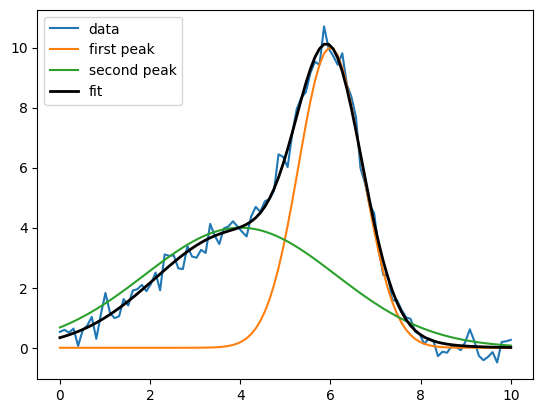

In [28]:
plot(t2,x2,label='data') # data
plot(t2,10*exp(-((t2-6)/1)**2),label='first peak') # a két becsült Gauss
plot(t2,4*exp(-((t2-4)/3)**2),label='second peak')
plot(t2,func2(t2,*popt),label='fit',color='black',linewidth=2) # fitted curve
legend(loc='upper left')

### Real life data 

`Felix Baumgartner stepped into the void nearly 128,000 feet (39,000 meters) above southeastern New Mexico Sunday at just after 12 p.m. MT (2 p.m. ET, 1800  GMT), then landed safely on the desert floor about 20 minutes later. His harrowing plunge shattered the skydiving altitude record, which had stood for more than 50 years, and it notched a few other firsts as well.`
* https://www.youtube.com/watch?v=rNhmYaWiPEk
* https://www.space.com/17961-supersonic-skydive-worlds-highest-space-jump.html

In the first phase of the jump, between $t=0\dots 40$ s, the motion is best described by free fall before the parachute opens. After that, drag is going to counter the gravitational force, and the velocity of the fall is going to become roughly constant in the interval $t=210\dots 260$ s.

Let us determine $g$ from the points at the beginning of the path, and let us determine the drag force using the last points of the path!

First, we [summarize](http://www.livescience.com/23710-physics-supersonic-skydive.html) the phenomena that we want to model.

**Free fall in the beginning**

Free fall is a constanly accelerated motion, thus, we can write the height as a function of time in the following form
$$h(t)=h_0+v_0t-\frac{g}{2}t^2.$$ The gravitational force can then be determined from the coefficients of the parabole fitted to the beginning of the jump, because the coefficient of the square term corresponds to $g/2$.

**Contant velocity motion in the end**

Because there is no acceleration, the drag force and the gravitational force are equal. Therefore, $$mg=\alpha v^2,$$ that leaves us with the drag being $\alpha=\frac{mg}{v^2}$. The [weight](http://www.livescience.com/23710-physics-supersonic-skydive.html) of Baumgartner is approximately 110 kg including equipment. We can determine $v$ from the fit.

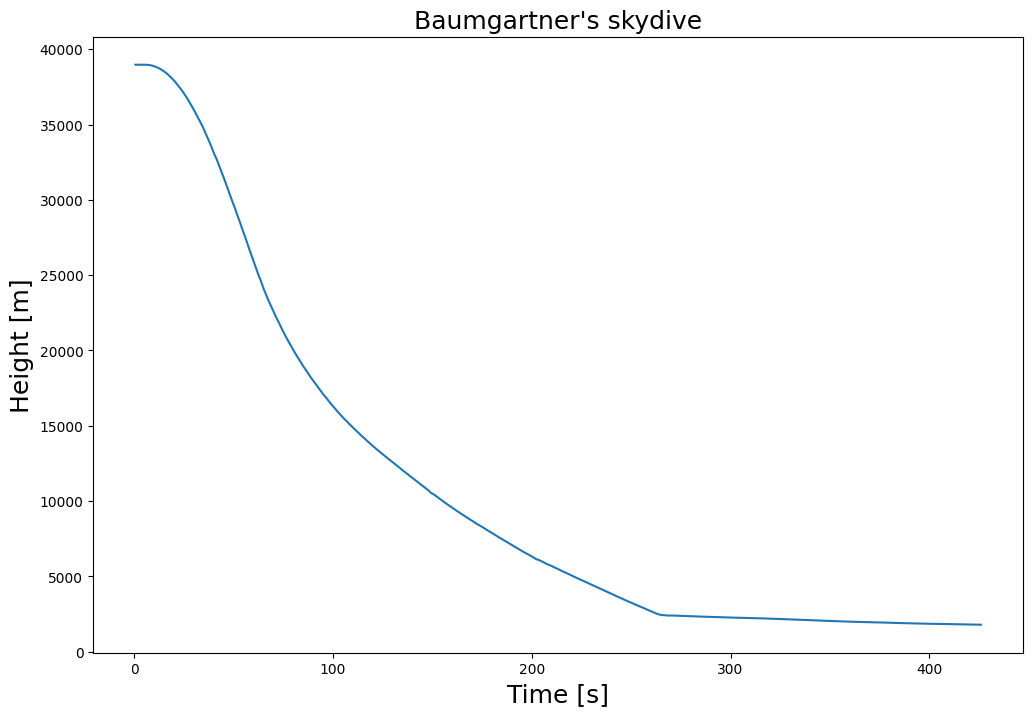

In [30]:
tB,h=loadtxt('data/h_vs_t',unpack=True) # reading data
# first column is time
# second column is height
figsize(12,8)
title("Baumgartner's skydive", fontsize=18)
plot(tB,h)
xlabel("Time [s]", fontsize=18)
ylabel("Height [m]", fontsize=18);

Let us now define the functions to be fitted, a linear one and a second order polynomial.

In [31]:
def linear(x,a,b):
    'Linear function: a*x+b'
    return a*x+b

def secondorder(x,a,b,c):
    'Second-order polynomial: a*x^2+b*x+c '
    return a*x**2+b*x+c

First we fit a second-order polynomial to the beginning of the data series. We can get the right part of the arrays by slicing them with the usual method.

In [32]:
p_beginning,pcov =curve_fit(secondorder,tB[tB<40],h[tB<40]) # fitting points with t<40
err_beginning = sqrt(diag(pcov))
# fitted parameter values and their error.
print('a=',p_beginning[0],'±',err_beginning[0]) 
print('b=',p_beginning[1],'±',err_beginning[1])
print('c=',p_beginning[2],'±',err_beginning[2])

a= -4.740475272922891 ± 0.028565970247357384
b= 45.238556631880385 ± 1.1603490866527297
c= 38893.934830606646 ± 9.870198986501713


$g$ is twice the fitted $a$ parameter!

In [33]:
g=abs(p_beginning[0]*2)
g

np.float64(9.480950545845783)

Let us now fit the linear segment, too. Again, we slice the arrays based on the time.

In [34]:
p_end,pcov =curve_fit(linear,tB[(tB>210)*(tB<260)],h[(tB>210)*(tB<260)]) # fitting points with t between 210 and 260
err_end = sqrt(diag(pcov))
# fitted parameter values and their error.
print('a=',p_end[0],'±',err_end[0]) 
print('b=',p_end[1],'±',err_end[1])

a= -60.16480248036339 ± 0.1459343539280443
b= 18299.00468934049 ± 34.355339394066156


The velocity now corresponds to the first fitted parameter. We can get $alpha$ from $\alpha=mg/v^2$.

In [35]:
v=p_end[0]
m=110
alpha= m*g/v**2
alpha

np.float64(0.28811082487969786)

Let's make a plot of all our results.

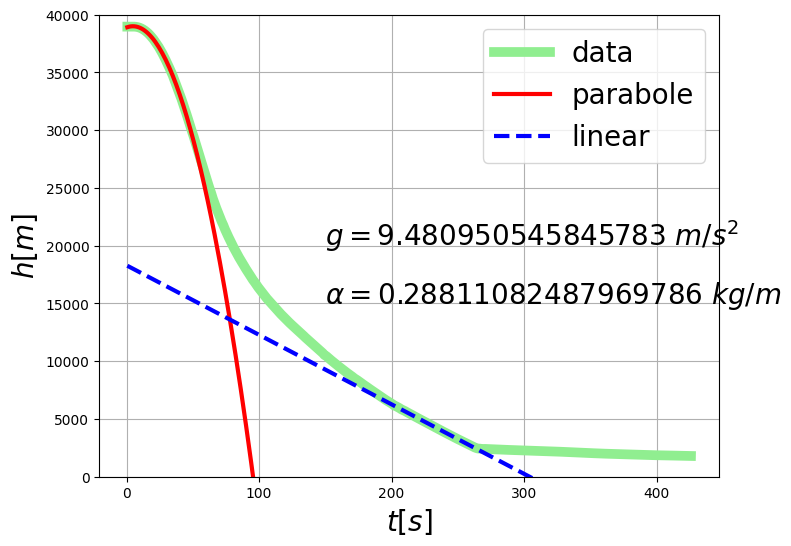

In [36]:
figsize(8,4*3/2)
plot(tB,h,label='data',linewidth=7,color='lightgreen')
plot(tB,secondorder(tB,*p_beginning),label='parabole',linewidth=3,color='red')
plot(tB,linear(tB,*p_end),label='linear',linestyle='dashed',linewidth=3,color='blue')
ylim(0,40000)
legend(fontsize=20)
xlabel(r'$t[s]$',fontsize=20)
ylabel(r'$h[m]$',fontsize=20)
text(150,20000,r'$g=$'+str(g)+r' $m/s^2$',fontsize=20)
text(150,15000,r'$\alpha=$'+str(alpha)+r' $kg/m$',fontsize=20)
grid()

In [37]:
figsize(6,4) #resetting figure size to the default values

## Periodic signals and the Fourier transformation

In many physical systems, some phenomena exhibit periodic behaviour. Perhaps the most everyday example is that of music. Many music players have built-in spectrum analyzers. These analyzers show the frequencies contained in the sound sample. The method that creates the frequency spectrum from a given sound sample is called [Fourier transformation](https://en.wikipedia.org/wiki/Fourier_transform). The Fourier transform of a function is defined by the following mathematical expression:
$$ \mathcal{F}[f](\nu)=\int^{\infty}_{-\infty} \mathrm{e}^{\mathrm{i 2\pi\nu t}}f(t)$$

There is a fast [algorithm](https://en.wikipedia.org/wiki/Fast_Fourier_transform) used for numerical Fourier transformation, that is used in many different packages. In Python, there is a submodule in the `numpy` package, `numpy.fft` that has this method implemented, we are going to use this submodule in the following examples. Note that we have already loaded this submodule at the beginning of this notebook.

First, let us generate a signal with $\nu$ frequency, that is,  $\omega=2\pi\nu$. This can be for example a $$f(t)=\sin(\omega t)$$ function. What is the Fourier transform of this function?

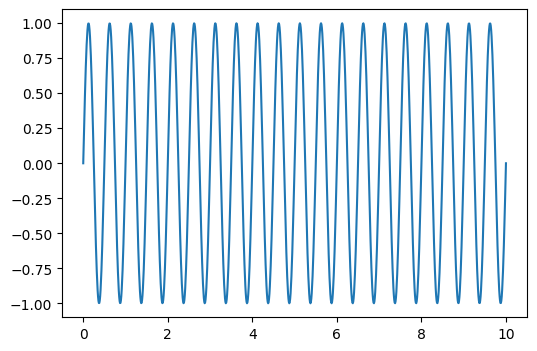

In [38]:
t3 = linspace(0,10,1000) # sampling time
nu=2;                   # frequency
omega=2*pi*nu           # omega
signal=sin(omega*t3)        # the signal
plot(t3,signal)


The Fourier transform is simple done by calling the `fft` function.

In [39]:
from numpy.fft import fft

In [40]:
Fsignal=fft(signal)

Now, the `Fsignal` variable contains the Fourier transform of the signal. As shown by the definition, Fourier transforms are usually complex. For most applications, it is enough to examine the absolute value of the Fourier transform. To be able to plot the transform as a function of frequency, we have to create a sample of frequencies, and this sample has to mnatch the original time sampling. The frequency sampling is done by the `fftfreq` function. This has two arguments: first is the length of the time series, and the second is the step in the time series, that is the difference between the subsequent elements.

In [41]:
freq = fftfreq(len(t3),t3[1]-t3[0])

Now we can plot the absolute value of the Fourier-transform.

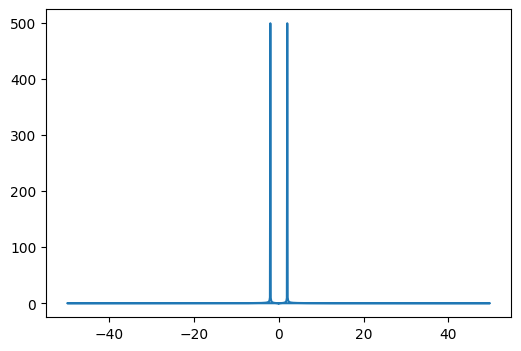

In [42]:
plot(freq,abs(Fsignal))

The Fourier transform is defined at both positive and negative frequency calues, but in the case of time-dependent signals, we can constrain the transform to only positive frequencies.

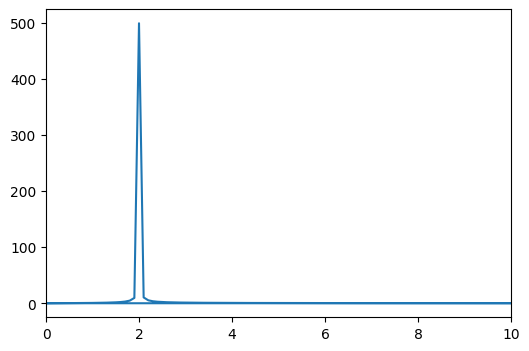

In [43]:
plot(freq,abs(Fsignal))
xlim(0,10);

Thus, a signal oscillating with a frequency of precisely 2, has a Fourier transform of a sharp peak at exactly two.

### Sun spots
Let us now examine the number of sunspots as a function of time. Can we observe the 11-year periodicity in the data? The sunspot data can still be found in the `data/SN_m_tot_V2.0.txt` file. Let's read it!

In [45]:
sunspot=loadtxt('data/SN_m_tot_V2.0.txt');

The third column is the time in years, and the fourth is the number of sunspots.

In [46]:
tN=sunspot[:,2]
N=sunspot[:,3]

Let us create the frequency sampling, and compute the Fourier transform.

In [47]:
freqN = fftfreq(len(tN),tN[1]-tN[0])
FN=fft(N)

Then, let us plot the Fourier spectrum.

Text(0.3, 60000, 'T=10.800000000017462 years')

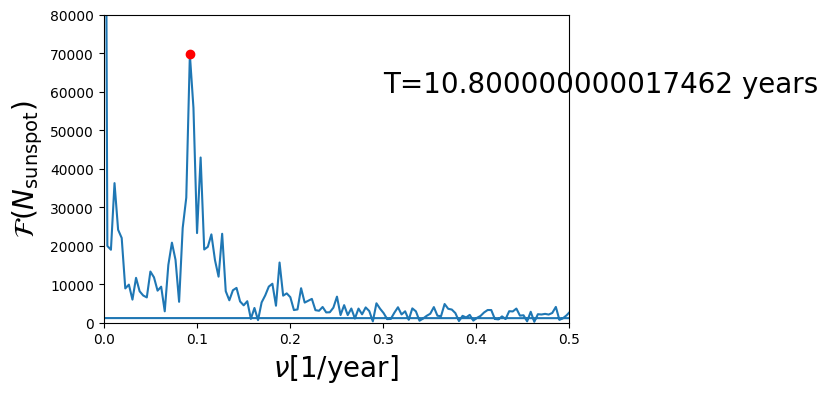

In [48]:
plot(freqN,abs(FN)) # plotting the spectrum
xlim(0,0.5)
ylim(0,80000)
# finding the maximum
maxN=max(abs(FN)[(freqN>0.03)*(freqN<0.2)])
maxf=freqN[(abs(FN)==maxN)*(freqN>0)]
plot(maxf,maxN,'o',color='red') # a red dot marking the peak
xlabel(r'$\nu [1/\mathrm{year}]$',fontsize=20)
ylabel(r'$\mathcal{F}(N_{\mathrm{sunspot}})$',fontsize=20)
text(0.3,60000,'T='+str(1/maxf[0])+' years',fontsize=20)

Thus, the Fourier transform has a sharp maximum at 10.8 years. This means that according to the Fourier transform of the observed data, there a roughly 11 years periodicity in the sun activity.

## Spectrograms

In many cases, we measure a signal that changes in time for much longer than the time scale of the sampling. A typical example is the analysis of sound samples. In these cases, apart from the Fourier transform of the whole sample, it can be useful to have a look at the change in the Fourier spectrum over time. The time dependent Fourier spectrum is the Fourier transform of some parts of the original sample. We can use the `spectrogram` function of the `scipy.signal` submodule to determine the time-dependent transform. Let us now look at an example.

First, let's generate a time series that has a signal with an accelerating frequency, a so-called [chirp](https://en.wikipedia.org/wiki/Chirp).

In [44]:
t4=linspace(0,10,5000) # sampling time
chirp=sin(2*pi*t4**2)  # this is the chirp

If we look at the shape of the signal, we see that the oscillations are becoming more frequent with time.

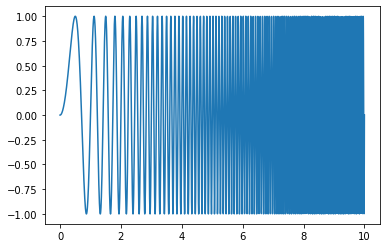

In [45]:
plot(t4,chirp)

The `spectrogram` function expects two input parameters. The first is the data series to examine, which is the `chirp` variable in out case, and the second is the sampling frequency of the data series. The sampling frequency can be determined by dividing the length of the whole time window by the number of sampling points.

In [46]:
fs=len(t4)/max(t4) # determining the frequency

Then the spectrogram is simply

In [47]:
freqs,ts,Schirp=spectrogram(chirp,fs)

The output of the above call is three `array` type variables, that we can visualize using the `pcolor` function. The first output variable contains the possible frequencies in the sample, the second is the time, and the third is the spectrogram itself. Let's plot the computed spectrogram!

Text(0, 0.5, '$\\nu$')

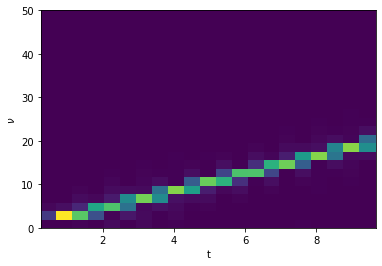

In [48]:
pcolor(ts,freqs,Schirp)
ylim(0,50);
xlabel('t')
ylabel(r'$\nu$')

We can see that there is one peak that has a uniformly growing frequency.